# HW 1: DP-Histogram and Non-private ERM for Logistic Regression

In this assignment, we will use the **Laplace mechanism** we learned in class to build a noisy histogram. The released (differentially private) noisy histogram can be used to generate synthetic data. In the second part, we build a _logistic regression_ model to perform a classfication task and train it using the **gradient descent** algorithm. We consider the logistic regression problem in non-private setting. In HW2, we will extend this algorithm to satisfy _differential privacy_ by implementing
- Gradient clipping and 
- Noise injection.

## Submission instruction
- Due by 11:59pm on **October 23, 2024**
- Complete this notebook and name it as "*CSCI8960\_HW1\_{your first name}.ipynb*".
- You should only use the functions **built-in** python.
- Do **not** use any other **3rd party libraries** unless you are asked to do so.
- If you're not sure whether you are allowed to use a certain function, contact your instructor.
- Do **not** _hardcode_ any data.
- Feel free to modify function prototype (i.e., you can add additional input parameters or remove existing ones based on your needs)
- Feel free to define your own functions if needed.
- Label your graphs.
- All the texts and labels in your graphs should be _legible_.

Let's start by importing required libraries.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Section 1: Private Synthetic Data Generation via Noisy Histograms

Consider the following dataset consisting of 1,000 observations
randomly generated using the `scikit-learn` package. You can
download the dataset from this
[link](https://cobweb.cs.uga.edu/~jwlee/datasets/dataset_hw4.csv). It 
contains two attributes $x_1$ and $x_2$ and a label $y$. As you can
see from the figure below, 
$(x_1, x_2)$-coordinate values are restricted to the range $[0,
1)$ <sup>[1](#notation1)</sup>. The label $y_i$, for $i=1, \ldots, 1000$,
is an integer, i.e., $y_i\in \{0, 1\}$. 0 and 1 correspond to the blue
and red dots in the figure, respectively. We will generate a synthetic
dataset that resembles the one in the figue under differential privacy. Here are steps we will be taking to generate the synthetic dataset.

### Building a 2D histogram
1. Construct bins by splitting each dimension into k intervals
2. Count the number of observations that fall into each bin.
    
    **Definition 1** (Histogram) A histogram $H=(b_1, \ldots, b_m)$ constructed from a dataset $D$ is a collection of bins $b_i$, each of which is a tuple $b_i = (r_1^i \times r_2^i, \text{count}_i)=([s_1^i,f_1^i)\times [s_2^i,f_2^i), \text{count}_i)$, where 
    - $\mathsf{rect}=(r_1^i\times r_2^i)$ denotes the rectangular region associated with $b_i$, and 
    - $\text{count}_i$ is the number of observations in $\mathsf{rect}$, i.e., $$|\{(x_1, x_2)\in D~|~s_1^i\leq x_1<f_1^i,\, s_2^i\leq x_2 < f_2^i\}\,.|$$
    
    For example, if we split each dimension into two intervals, $[0, 0.5)$ and $[0.5, 1.0)$, we obtain $2 \times 2 = 4$ bins in total. Each bin is composed of 2D <tt>range</tt> and <tt>count</tt>. The <tt>range></tt> is a Cartesian product of two intervals, one from dimension $x_1$ and the other from $x_2$. The <tt>count</tt> is an integer that represents the number of observations falling into the rectangle formed by the associated <tt>range</tt>. An example of 2D histogram is shown in the table below<sup>[2](#notation2)</sup>. Alternatively, this can be viewed as laying a regularly spaced grid over a rectangle $[0, 1) \times [0, 1)$ and counting number of observations contained in each cell.        
    | Bin   | $b_i$.range      | $b_i$.count  |
    | ----- | :-------------------: |   -------------------: |
    | $b_1$ | $[$ 0, 0.5 $) \,\times\, [$ 0, 0.5 $)$   | 123 |
    | $b_2$ | $[$ 0, 0.5 $) \,\times\, [$ 0.5, 1.0 $)$ | 377 |
    | $b_3$ | $[$ 0.5, 1.0 $) \,\times\, [$ 0, 0.5 $)$ | 346 |
    | $b_4$ | $[$ 0.5, 1.0 $) \,\times\, [$ 0.5, 1.0 $)$ | 154 |


<sup>[1](#notation1)</sup>: The notation $[a, b)$ means the interval defined by $a\leq x < b$. The left square bracket means that the lower bound $a$ is inclusive while the right parenthesis means that the upper bound is not inclusive.

<sup>[2](#notation2)</sup>: Note that the count values in the talbe are not calculated from the dataset you will be using in this homework. In other words, even if you get different count values, it doesn't mean that your implementation is incorrect.


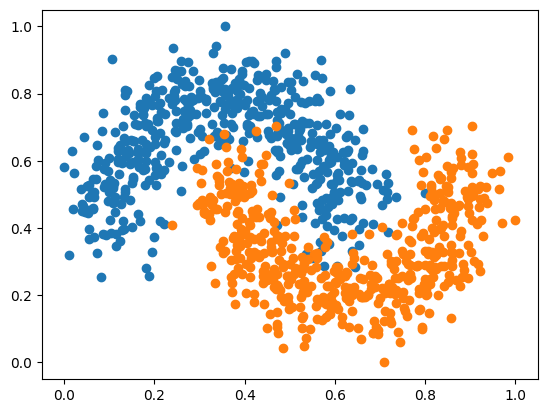

In [4]:
df = pd.read_csv("dataset_hw4.csv", names=['x1', 'x2', 'y'])
plt.scatter(df[df['y'] == 0]['x1'], df[df['y'] == 0]['x2'], c='C0')
plt.scatter(df[df['y'] == 1]['x1'], df[df['y'] == 1]['x2'], c='C1')

### Q1. (5 pts) Implement the function that constructs a histogram.

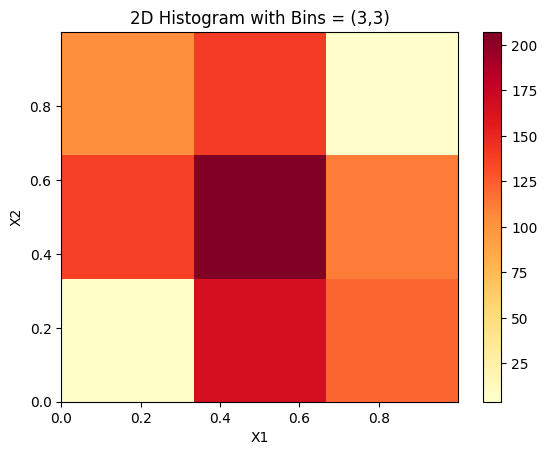

[121 112   4 167 207 140   7 138 104]
[121, 112, 4, 167, 207, 140, 7, 138, 104]


In [118]:
def construct_histogram(X, n_split):        
    """
    Parameters:
    --------------------------
    X: 2D array of size (n, 2), containing observations
    n_split: integer, the number of intervals to have on each dimension

    Return:
    -------------------------
    h: 1D array containing bin counts; the bins are enumerated from left to
       right and top to bottom. For our example in Table 1, it should return
       (377, 154, 123, 346) = (b2, b4, b1, b3).
    """
    
    x1_bins = [i/n_split for i in range(n_split+1)]
    x2_bins = [i/n_split for i in range(n_split+1)]
    
    x_categorized = pd.cut(X['x1'], bins=x1_bins, right=False)
    y_categorized = pd.cut(X['x2'], bins=x2_bins, right=False)

    bin_counts = pd.crosstab(x_categorized, y_categorized)
    bin_counts_1d = bin_counts.values[::-1].ravel(order='C')
        
    
    hist_bins = plt.hist2d(X['x1'],X['x2'], bins=(n_split,n_split),cmap='YlOrRd')
 
    # Adding labels and title
    plt.xlabel('X1')
    plt.ylabel('X2')

    title = "2D Histogram with Bins = ("+str(n_split)+","+str(n_split)+")"
    plt.title(title)
    
    # Adding colorbar
    plt.colorbar()
    # Display the plot
    plt.show()

    # Find the count for each bin
    output_binCount = []
    output_binName = []
    counter = 0

    for row in reversed(hist_bins[0]):
        for col in row:
            counter += 1
            output_binCount.append(int(col))
            output_binName.append('b'+str(counter))
    # Return bin counts in a 1D array (Can uncomment to also add bin names)

    


    return (output_binCount)#,output_binName)

# Call and return histogram, then print
histogram = construct_histogram(df,3)
print(histogram)

We now consider releasing the histogram that we constructed above.

### Releasing the histogram using the Laplace mechanism

Given a query function $q:\mathcal{X}^n \to \mathbb{R}$, the Laplace mechanism $\mathcal{M}$ first computes the true answer $q(D)$ and draw a random noise $Y$ from a Laplace distribution $\mathsf{Lap}(0, \lambda)$ with mean 0 and scale factor $\lambda$. We saw in class that setting $\lambda = \frac{\Delta_q}{\epsilon}$ allows to achieve $\epsilon$-differential privacy:

$$
  \mathcal{M}_q(D) = q(D) + Y\,, \quad Y\sim \mathsf{Lap}(0, \lambda)\,.
$$
We also learned in class how to release histograms (a sequence of count values) under differential privacy. As a warm-up, let's compute the sensitivity of releasing histograms.


### Q2. (5 pts) Derive the sensitivity of releasing the histogram under both proper subset and replacement definition. You need to show your work using the [Markdown](https://docs.github.com/en/get-started/writing-on-github/working-with-advanced-formatting/writing-mathematical-expressions) syntax.

#### Answer for Q2:

Proper Subset: Removing a single individual from this dataset and how much could that change the bin counts. Removing a single individual will change the bin count of only 1 bin. All but 1 bin will remain constant, and the bin that changes will change by 1. Given sensitivity is usually $L_{1}$ norm of this difference, the total sensitivity will be $\underset{D,D' \in \mathcal{U}}{max}||q(D) - q(D')||_{1} = 1$. Where D and D' are neighboring datasets such that D' is missing 1 individual from D. The steps below will walk through the calculation of sensitivity.

Step 1: Define the Histogram binning algorithm as $Q: (X_{1},X_{2}) \rightarrow H$, where $H$ is the count of data points in each of the $k*k$ bins. 

Step 2: Assume k bins.

Step 3: Remove 1 individual.

Step 4: One of the k bins will decrease their count by 1. The remaining k-1 bins will remain unchanged.

Step 5: $\underset{D,D' \in \mathcal{U}}{max}||q(D) - q(D')||_{1} = \lvert 1 \rvert+ (k-1)*0 = 1$


Replacement: Changing a single individual from this dataset and how much could that change the bin counts. Changing a single individual will change the bin count of 2 bins. 1 bin will lose a count, and another bin will gain a count. All other bins will remain constant. Given sensitivity is usually $L_{1}$ norm of this difference, the total sensitivity will be $\underset{D,D' \in \mathcal{U}}{max}||q(D) - q(D')||_{1} = 2$. Where D and D' are neighboring datasets such that D' changes 1 individual from D. The steps below will walk through the calculation of sensitivity.

Step 1: Define the Histogram binning algorithm as $Q: (X_{1},X_{2}) \rightarrow H$, where $H$ is the count of data points in each of the $k*k$ bins. 

Step 2: Assume k bins.

Step 3: Change 1 individual.

Step 4: One of the k bins will decrease their count by 1, another will increase their count by 1. The remaining k-2 bins will remain unchanged.

Step 5: $\underset{D,D' \in \mathcal{U}}{max}||q(D) - q(D')||_{1} = \lvert 1  \rvert + \lvert -1 \rvert + (k-2)*0 = 2$












Now we are ready to write a function that release histogram under $\epsilon$-differential privacy.
    
### Q3. (5pts) Write a function that releases a histogram using the Laplace mechanism. 

- You can use `numpy.random.laplace` to generate the Laplace noise.
- Post-porcess your histogram so that there is no negative values in your histogram

    A drawback of using the Laplace mechanism for releasing histograms is that the released count values can be negative and are real numbers (rather than integers). What we learned in class is that the privacy guarantee of differential privacy is invariant under *post-processing*. This means that we can freely transform the differentially privately released output and the result is still $\epsilon$-differentially private as long as the algorithm you used to transform the output doesn’t make use of the noise injected by the Laplace mechanism.
    
   
- You should normalize your histogram to convert the counts into probabilities.


In [87]:
def dp_histogram(histo, epsilon):
    """
    Parameters:
    ------------------------
    histo: 1D array containing count values of a histogram
    epsilon: privacy budget, a real number greater than 0.

    Returns:
    ------------------------
    noisy_histo: 1D array containing normalized count values, i.e., probabilities for each bin
    """
    noisy_histo = histo.copy()
    sensitivity = 2
    # add noise
    for index,i in enumerate(histo):
        noisy_histo[index] = i + np.random.laplace(sensitivity/epsilon)
    
    # shift to eliminate negative values, if needed
    min_value = min(noisy_histo)
    if min_value < 0:
        for index,i in enumerate(noisy_histo):
            noisy_histo[index] = i + min_value
    
    # calculate probabilities
    sum_value = sum(noisy_histo)
    for index,i in enumerate(noisy_histo):
        noisy_histo[index] = i/sum_value

    return noisy_histo

dp_histogram = dp_histogram(histogram, 5) 
print(dp_histogram)

    

[0.32327433838443126, 0.15189296037857025, 0.1814079989047934, 0.343424702332205]


### Generating a synthetic dataset using the noisy histogram

Let's recall the information available to us. We have a noisy histogram
$$
    \widetilde{H} = (b_1, b_2, \ldots, b_n) = \{b_i=([s_1^i, f_1^i) \times [s_2^i, f_2^i),
    \mathtt{count}_i, \mathtt{prob}_i)\}_{i=1}^n
$$
containing <tt>count</tt> and <tt>prob</tt> for each rectangle formed by two intervals. This tells us that we can create a dataset by generating $\mathtt{count}_i$ observations within the range $[s_1^i, f_1^i)\times [s_2^i, f_2^i)$. 

For simplicity, we **assume** observations are *uniformly distributed* over $[s_1^i, f_1^i) \times [s_2^i, f_2^i)$. You can use `numpy.random.uniform` to randomly generate uniformly distributed values.

### Q4. (5 pts) Write a function that generate a synthetic dataset of size $1,000$.

In [28]:
def synthesize_dataset(noisy_histo):
    """      
    Parameters:
    -------------------------
    noisy_histo: tuple containing bin ranges and bin counts
    
    Returns:
    -------------------------
    syn_dataset: 2D array containing
    """
    bounds = []
    n_split = np.sqrt(len(noisy_histo))
    for i in n_split:
        bounds.append()


    for i in range(1000):
        random_number = np.random.select(p=noisy_histo)

### Q5. (10 pts) Generate and visualize the synthetic datasets.
- generate datasets using three different values of $\epsilon = 0.1, 1.0, 10.0$ and for three different values of `n_split`=2, 4, 8. 
- You should provide 3 × 3 = 9 visualizations.
- Discuss the results in the context of privacy/utility trade-off.

# Section 2: Logistic Regression

For this assignment, we will be using the telco customer churning dataset. You can dowload the dataset from [here](http://cobweb.cs.uga.edu/~jwlee/datasets/churn.csv).

### About the dataset
Our goal is to build a logistic regression model for predicting whether the customer will churn or not, i.e., the churn column.

| Feature | Description |
|:-------:|:----------:|
|customerID | Customer ID |
| gender | Whether the customer is a male or a female |
| SeniorCitizen | Whether the customer is a senior citizen or not (1, 0)|
|Partner | Whether the customer has a partner or not (Yes, No) |
| Dependents | Whether the customer has dependents or not (Yes, No)|
| tenure | Number of months the customer has stayed with the company|
|PhoneService | Whether the customer has a phone service or not (Yes, No)|
| MultipleLines | Whether the customer has multiple lines or not (Yes, No, No phone service)|
| InternetService | Customer’s internet service provider (DSL, Fiber optic, No)|
| OnlineSecurity | Whether the customer has online security or not (Yes, No, No internet service) |
| OnlineBackup | Whether the customer has online backup or not (Yes, No, No internet service)|
| DeviceProtection | Whether the customer has device protection or not (Yes, No, No internet service)|
| TechSupport | Whether the customer has tech support or not (Yes, No, No internet service)|
| StreamingTV | Whether the customer has streaming TV or not (Yes, No, No internet service)|
| StreamingMovies | Whether the customer has streaming movies or not (Yes, No, No internet service) |
| Contract | The contract term of the customer (Month-to-month, One year, Two year)|
| PaperlessBilling | Whether the customer has paperless billing or not (Yes, No)| 
| PaymentMethod | The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)) | 
| MonthlyCharges | The amount charged to the customer monthly| 
| TotalCharges | The total amount charged to the customer| 
| Churn | Whether the customer churned or not (Yes or No) | 

## Part 2. Pre-processing the dataset

Let's preprocess the dataset for our analysis.

### Q1. (10 pts) Load the dataset into a dataframe and performs the one-hot encoding.

1. load the dataset into a dataframe. 
2. If there are any observations with missing values, report their number and remove them.
3. `Churn` column contains class labels (two distinct values `Yes` and `No`).
4. Use one-hot encoding to convert categorical features into numerical ones.    
    - There are multiple way for you to apply the one-hot encoding. Possible choices include:
    - Scikit learn's OneHotEncoder class (See [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html))
    - Padas's `DataFrame` also provides a method: [`pandas.get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)
5. When you apply the **one-hot encoding**, make sure that you **exclude** the first column (In the example below, this corresponds to the is\_DSL column).
6. For the three numerical variables, scale the features to ensure their values are in [0, 1]. Recall that we discussed the "feature scaling" in class.
     - The scaling maps the minumn and maximum values of each feature to 0 and 1, respectively.
     - You can manually implement this using a datframe's feature (e.g., `df.apply()`).
     - You can use `sklearn.preprocessing.MinMaxScaler`. **See** [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for details.
7. Encode your label column (i.e., `Churn`).
    - Map "No" to 0 and "Yes" to 1.
    - `sklearn.preprocessing.LabelEncoder` performs this mapping.
8. Print out the number of observations and features after the pre-processing.

Consider the InternetServics variable in your data. It is a cateorical variable with 3 distinct values: DSL, fiber optic, no. Let's encode the variable using the **one-hot** encoding we used in HW5. This time you can use the function implemented in `pandas` package. See the following example of applying the one-hot encoding to the InternetService variable.

| Internet Service |
|:------------:|
|  DSL         |
|  DSL         |
|  fiber optic         |
|  no         |

With one-hot encoding, this will be converted into 

| is_DSL | is_fiberOptic | is_No |
|:------:|:------:|:------:|
|   1    |   0    |    0   |
|   1    |   0    |    0   |
|   0    |   1    |    0   |
|   0    |   0    |    1   |.

Notice that a categorical variable with 3 distinct values is represented by a binary vector of length 3. In the previous homework, you manually applied the one-hot encoding. In this homework, you are allowed to use either `pandas.get_dummies()` or `sklearn.preprocessing.OneHotEncoder`. **PLEASE**, read the documentation pages ([get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) and [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)) for their usages and examples.


In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder


#-------------------------#
#  Your code goes here.   #
#-------------------------#







As we talked in class, we can remove the bias term from the equation by adding a dummy column to the input dataset. In practice, we don't actually need to materialize this dummy column, but in here we will add it to keep the things simple. After adding a dummy column, you dataset will look like:
$$ \mathbf{X} = 
\begin{pmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1p} \\
1 & x_{21} & x_{22} & \cdots & x_{2p} \\
\vdots & \vdots & \vdots  & \ddots & \vdots \\
1 & x_{n1} & x_{n2} & \cdots & x_{np}
\end{pmatrix}
$$

### Q2. (2 pts) Augment the dataset by adding a dummy column of ones .

In [ ]:
   
#-------------------------#
#  Your code goes here.   #
#-------------------------#
   

### Q3-1. (3 pts) Ensure that your dataset has $Y \in \{-1, +1 \}$ .
In simplified notation, it is assumed that $y_i \in \{-1, +1\}$. To satisf this assumption, we will **map <font color="red"> "No" to -1 and "Yes" to +1</font>**.
- Write a code that shows your y values indeed has domain of $\{-1, +1\}$.

In [4]:
  
    #-------------------------#
    #  Your code goes here.   #
    #-------------------------#
    
    

### Q3-2 (2pts) Split the data into train and test sets.
- Use `sklearn.model_selection.train_test_split()` function
- Use 80% of observations for training and the rest for testing.

In [ ]:
from sklearn.model_selection import train_test_split

#-------------------------#
#  Your code goes here.   #
#-------------------------#



## Part 2. Logistic Regression Model

Now we are ready to build our classfication model. Recall that logistic regression model tries to learn the conditional probability using a sigmoid function:
$$ \Pr[Y = y_i~|~X=x_i] = \sigma(y_i\beta^\intercal x_i) \quad \text{ for }i=1, \ldots, n\,, $$
where $\beta = (\beta_0, \beta_1, \ldots, \beta_p)^\intercal$.

Recall the **empirical risk minimization** framework we discussed in class in which our goal for _logistic regression_ is to minimize the following *empirical logistic loss*:
$$ \underset{\mathbf{\beta} \in \mathbb{R}^{p+1}}{\text{minimize}}\, \mathbb{E}[\ell(\beta)] \approx \frac{1}{n}\sum_{i=1}^n \log (1 + \exp(-y_i\mathbf{\beta}^\intercal\mathbf{x}_i))\,, $$
and its gradient is given by
$$ \frac{\partial \ell(\mathbf{\beta})}{\partial \mathbf{\beta}} = -\frac{1}{n}\sum_{i=1}^n (1 - \sigma(y_i\mathbf{\beta}^\intercal\mathbf{x}_i))y_i\mathbf{x}_i\,. \qquad\qquad (1) $$

I strongly recommend you to derive and verify the above equation for the gradient by yourself. One simple but powerful method you can use to solve the above optimization problem is **<font color="red">gradient descent</font>** algorithm. Starting from an inital solution $\beta^{(0)}$, it iteratively computes the *gradient* at the given location $\beta^{(k)}$ and updates the solution as follows:
$$\beta^{(k+1)} = \beta^{(k)} - \eta_k \nabla \ell(\beta^{(k)})\,,$$
where
- $\beta^{(k)}$ denotes the parameter vector at iteration $k$,
- $\eta_k > 0$ is the step size for iteration $k$, and 
- $\nabla \ell(\beta^{(k)})$ is the gradient of the objective function at $\beta^{(k)}$.


### Q4. (10 pts) Implement the objective function of logistic regression model.
- You will get the full mark on this question if you implement this without using a for-loop.

Given a numpy array $\beta$, the `logres_obj()` function should return 
$$ \frac{1}{n}\sum_{i=1}^n \log(1 + \exp(-y_i\beta^\intercal x_i))\,.$$

**<font color="red">Hint</font>**: let 
$$ W = \begin{pmatrix}
w_{11} & w_{12} & w_{13} \\
w_{21} & w_{22} & w_{23} \\
w_{31} & w_{32} & w_{33} \\
w_{41} & w_{42} & w_{43} 
\end{pmatrix} \in \mathbb{R}^{4\times 3}\,,\quad q = \begin{pmatrix}
q_1 \\ q_2 \\ q_3 \\ q_4 \end{pmatrix} \in \mathbb{R}^{4\times 1}\,, \quad \text{ and } \alpha = 
\begin{pmatrix}
\alpha_1 \\ \alpha_2 \\ \alpha_3 
\end{pmatrix} \in \mathbb{R}^{3 \times 1}.$$
Then, we can compute $\sum_{i=1}^4 \alpha^\intercal w_i = \sum_{i=1}^4 w_i^\intercal \alpha$ as follows:
$$
\sum_{i=1}^4 \alpha^\intercal w_i 
= \text{np.sum}\left\{W \alpha\right\}
= \text{np.sum}\left\{
\begin{pmatrix}
\alpha^\intercal w_1 \\
\alpha^\intercal w_2 \\
\alpha^\intercal w_3 \\
\alpha^\intercal w_4 
\end{pmatrix} \right\}\,,
$$
where $w_i = (w_{i1}, w_{i2}, w_{i3})$, i.e, the $i^\mathrm{th}$ row. See the following example.

In [3]:
W = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
alpha = np.array([1, 2, 3])
q = np.array([1, 2, 3, 4])

sum_wa = np.sum(np.dot(W, alpha), axis=0)
print(sum_wa)

164


If you want to compute $\sum_{i=1}^4 \log(\alpha^\intercal w_i)$, you can do 
$$
\sum_{i=1}^4 \log\alpha^\intercal w_i 
= \text{np.sum}\left\{\text{np.log}(W \alpha)\right\}
= \text{np.sum}\left\{
\begin{pmatrix}
\log \alpha^\intercal w_1 \\
\log\alpha^\intercal w_2 \\
\log\alpha^\intercal w_3 \\
\log\alpha^\intercal w_4 
\end{pmatrix}, axis=0 \right\}\,,$$

In [5]:
log_wa = np.log(np.dot(W, alpha))
print(np.sum(log_wa, axis=0))

14.236323943019237


$$\sum_{i=1}^4 w_i q_i = \text{np.sum}\left\{ 
\begin{pmatrix}
q_1 \cdot w_1 \\
q_2 \cdot w_2 \\
q_3 \cdot w_3 \\
q_4 \cdot w_4 
\end{pmatrix}, axis=0\right\}\,.$$ Refer to the lecture slides on <font color="red">numpy array broadcasting</font>.

In [7]:
print("q.shape=", q.shape)
q2d = np.atleast_2d(q)
print("q2d.shape=", q2d.shape)
q2d = q2d.T
print("(after transpose) q2d.shape=", q2d.shape)
print(W * q2d)

q.shape= (4,)
q2d.shape= (1, 4)
(after transpose) q2d.shape= (4, 1)
[[ 1  2  3]
 [ 8 10 12]
 [21 24 27]
 [40 44 48]]


In [ ]:
def logres_obj(X, y, beta):
    """
    returns the objective value of the logistic regression model
    
    Parameters:
    ------------
    X, y: numpy arrays representing the input dataset
    beta: numpy array correspoinding to the parameter vector
    
    Output:
    -------
    obj: objective value (scalar)
    """
    #-------------------------#
    #  Your code goes here.   #
    #-------------------------#
    
    
    
    
    return obj


# test code assuming (train_X, train_y) represents your training dataset
beta = np.zeros(X_train.shape[1])
print(logres_obj(X_train, y_train, beta))

beta = np.ones(train_X.shape[1])
print(logres_obj(X_train, y_train, beta))

### Q5. (10 pts) Implement the function that returns the gradient of logistic regression model.
The `logres_grad()` function should return
$$\frac{1}{n}\sum_{i=1}^n (\sigma(y_i\mathbf{\beta}^\intercal\mathbf{x}_i)-1)y_i\mathbf{x}_i \,.$$

Note that the output is a gradient (1D numpy array of length $p+1$). 
- You should carefully distinguish vectors from scalars.
- Use the python's implementation of simoid function, `scipy.special.expit()` (check its documentation [here](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.special.expit.html))
- To help your implementation, a function you can use to numerically approximate the gradient is provided. See `finite_diff_grad()` function below.

In [ ]:
def finite_diff_grad(X, y, beta, h=0.00001):
    """ 
    This function numerically evaluates the gradient of the objective function at beta
    """ 
    
    f_beta = logres_obj(X, y, beta)
    
    p = len(beta)
    grad = np.zeros(p)
    
    for i in range(p):
        e = np.zeros_like(beta)
        e[i] = h
        
        # evalute f(x+h)
        f_beta_h1 = logres_obj(X, y, beta+e)
        
        # evaluate f(x - h)
        f_beta_h2 = logres_obj(X, y, beta-e)
        
        grad[i] = (f_beta_h1 - f_beta_h2) / (2.0 * h)
        
    return grad

In [ ]:
from scipy.special import expit


def logres_grad(X, y, beta):
    """
    returns the gradient of logistic regression model
    
    Parameters:
    ------------
    X, y: numpy arrays representing the input dataset
    beta: numpy array correspoinding to the parameter vector
    
    Output:
    -------
    grad: 1D numpy array
    """
    ######################################
    #         Your code goes here        #
    ######################################
    
    
    return grad 


# test code
"""
The outputs of two functions, logres_grad() and finite_diff_grad(), should be 
approximately the same.
"""
grad_analytic = logres_grad(X, y, beta)
grad_numeric = finite_diff_grad(X, y, beta)

print("L2 distance=", np.linalg.norm(grad_analytic - grad_numeric))

### Q6. (10 pts) Implment the Gradient Descent Algorithm
Using the two functions `logres_obj()` and `logres_grad()`, implement the gradient descent algorithm. The core of gradient descent algorithm is $$\beta^{(k+1)}=\beta^{(k)}-\eta\nabla f(\beta^{(k)})$$

1. Initialize the $\beta^{(0)} = (0, 0, \ldots, 0)^\intercal$.
2. Use the fixed step size $\eta$.

In [ ]:
def grad_desc(X, y, n_iter=100):
    """
    gradient descent algorithm
    
    Parameters:
    ----------------
    X, y: input dataset
    n_iter: the number of iterations
                 
    Returns:
    -----------
    sol_path : a list of solutions, the kth entry corresponds to the beta 
               at iteration k
    obj_vals : a list of object values, the kth entry corresponds to the 
               objective value at iteration k               
    """
    sol_path = []
    obj_vals = []
    eta = 1.0    
    
    n, p = X.shape
    
    # initialize your parameter vector, beta, here
    
    for i in range(n_iter):
        
        #---------------------------#
        #    Your code goes here    #
        #---------------------------#
        
        
    return sol_path, obj_vals 



## Prediction
Recall that in logistic regression we set 
$$ \Pr(Y=1~|~X=x) = \sigma(\mathbf{\beta}^\intercal\mathbf{x}). $$
Our prediction will be
$$
Y = \begin{cases}
1 & \mbox{ if $\Pr[Y=1~|~X=x] \geq 0.5$} \\
-1 & \mbox{ otherwise.}
\end{cases}
$$
Since the sigmoid function $\sigma(x)$ is greater than or equal to 0.5 when $x\geq 0$ (refer to the figure below), we will predict $Y=1$ when $\mathrm{sign}(\beta^\intercal x)$ is positive.  

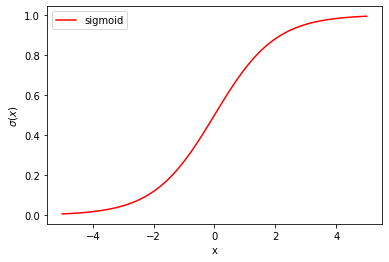

In [10]:
x = np.linspace(-5, 5, 100)
y = expit(x)

fig, ax = plt.subplots()
ax.plot(x, y, 'r-', label='sigmoid')
ax.set_xlabel('x')
ax.set_ylabel(r'$\sigma(x)$')
ax.legend()

### Q7. (10 pts) Implement a function that predicts the labels for the given examples.

In [ ]:
def predict(X, beta):
    """
    predict the labels of observations in X
    
    Parameters:
    ----------------
    beta: coefficients
    X: 2D numpy array, a set of observations, an example per row
    
    Returns:
    y_hat: predicted labels    
    """
    
    #---------------------------#
    #    Your code goes here    #
    #---------------------------#

    
    return y_hat

## Part 3. Training
Now we're ready to train the logistic regression model using our implementation of gradient descent. Let's train a logistic regression model using the functions you implemented.

In [ ]:
n_iter = 500
sols, objs = grad_desc(X_train, y_train, n_iter=n_iter)

We have 500 elements in the array `sols`, and each element is an estimate of $\beta$ (or solution) at iteration $k$. We can expect that the accuracy of $\beta$ improves as $k$ increases.

### Q8. (3 pts) Draw a plot showing how the objective values change as we do more gradient descent updates.
In other words, x-axis = iteration number $k$ and y-axis = objective value at iteration $k$.

In [ ]:

#-----------------------------#
#  Your code goes here        #
#-----------------------------#



### Q9. (10 pts) Using the function `predict()` and estimates in `sols`, compute training and test errors (5 pts). 
- use 'red'solid line and 'blue' dotted line for training and testing, respectively.
- set the figsize=(10, 6.5)
- For your convenience, the code for computing the accuracies of solutions on the solution path is provided below.

In [ ]:
def compute_accuracy(testX, testY, sols):
    """
    returns the accuracy of each solution on the given dataset
    
    accuracy = percentage of correctly classified examples
    
    Parameters
    -----------
    testX, testY: input dataset
    sols: a list of parameter vectors
    
    Returns
    --------
    acc: a list of accuracies, each element corresponds to the accuracy of each solution in sols
    """
    acc = []
    
    n_examples = len(testY)
    
    for sol in sols:  
        pred = predict(testX, sol)
        n_correct = n_examples - np.count_nonzero(testY - pred)
        acc.append((n_correct*100.0)/n_examples)
        
    return acc

train_accs = compute_accuracy(X_train, y_train, sols)
test_accs = compute_accuracy(X_test, y_test, sols)

# plot the training/test errors against iterations
# you need to have two series (or lines) in a single plot


#-----------------------------#
#  Your code goes here        #
#-----------------------------#

